********************

In [1]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False   # 解决负号显示问题


# 1. Agent学生主体

In [2]:


import random
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from numpy.random import normal
from mesa.datacollection import DataCollector  # 导入数据收集器，用于记录模型和主体的数据。
import networkx as nx


# 学生主体类
class StudentAgent(Agent):
    def __init__(self, unique_id, model, summer_start, summer_end, winter_start, winter_end, holiday_effects, profile="normal", grade=None, faculty=None, green_education=False,c_d_ratio=(0.5, 0.5)):
        """
        初始化学生主体。
        Args:
            unique_id (int): 学生唯一编号。
            model (Model): 模型对象。
            summer_start (str): 暑假开始日期（YYYY-MM-DD）。
            summer_end (str): 暑假结束日期（YYYY-MM-DD）。
            winter_start (str): 寒假开始日期（YYYY-MM-DD）。
            winter_end (str): 寒假结束日期（YYYY-MM-DD）。
            holiday_effects (dict): 假期效应字典，键为日期字符串（YYYY-MM-DD），值为假期类型。
            profile (str): 学生行为类型。
            grade (str): 学生年级。
            faculty (str): 学生专业。
            green_education (bool): 是否参与绿色教育课程。
        """
        super().__init__(unique_id, model)
        # print(self.current_date)
        self.is_on_campus = True  # 是否在校状态

        # 设置寒暑假信息
        self.summer_start = datetime.strptime(summer_start, "%Y-%m-%d")
        self.summer_end = datetime.strptime(summer_end, "%Y-%m-%d")
        self.winter_start = datetime.strptime(winter_start, "%Y-%m-%d")
        self.winter_end = datetime.strptime(winter_end, "%Y-%m-%d")

        # 假期效应和参数
        self.holiday_effects = holiday_effects

        # 社会学信息
        self.profile = profile
        self.grade = grade
        self.faculty = faculty
        self.green_education = green_education
        self.c, self.d = c_d_ratio

        # 基础用水量
        self.base_consumption = self.calculate_base_consumption()

        # 每天淋浴和洗衣服的概率
        self.shower_probs = [0.63, 0.66, 0.66, 0.65, 0.62, 0.62, 0.64]
        self.laundry_probs = [0.40, 0.40, 0.40, 0.40, 0.45, 0.45, 0.45]

        # 内嵌的暑假和寒假多项式系数
        self._summer_coefficients = [8.60987857e-01, 1.36859624e-02, -1.99858329e-03, 5.92193526e-05, -7.76982757e-07, 3.99970679e-09]


        self._winter_coefficients = [0.7645638874513381, -0.0013731766863659181, -0.0057098630785314556, 0.00027673512470457806, -4.405621735518008e-06, 2.3663790433562584e-08]
        self.summer_probability_poly = Polynomial(self._summer_coefficients)
        self.winter_probability_poly = Polynomial(self._winter_coefficients)


    def calculate_behavior_utilities(self, neighbors_behavior):
        """
        根据邻居行为计算行为效用。
        """
        V_env = neighbors_behavior["environmentalist"]
        V_normal = neighbors_behavior["normal"]

        # 根据是否接受绿色教育，获取行为效用的系数【这个系数设置的太小，会使得转变和不转变收到邻居的影响较小，同样a/b/c/d不要求加起来和为1之类的】
        if self.green_education:
            a, b, c, d = 0.7, 0.3, self.c, self.d
        else:
            a, b, c, d = 0.7, 0.3, 0.3, 0.7

        if self.profile == "environmentalist":
            U_env_to_env = a * V_env
            U_env_to_normal = b * V_normal
            return U_env_to_env, U_env_to_normal
        else:  # self.profile == "normal"
            U_normal_to_env = c * V_env
            U_normal_to_normal = d * V_normal
            return U_normal_to_env, U_normal_to_normal

    def calculate_base_consumption(self):
        """定义基础设备的每日用水量（单位：升）。"""
        # 根据 profile 设置基础用水量
        if self.profile == "environmentalist":
            base_usage = {"toilet": 20, "sink": 25}
        else:  # profile == "normal"
            base_usage = {"toilet": 30, "sink": 50}
        
        return sum(base_usage.values())

    def calculate_daily_water_usage(self):
        """计算每日用水量。"""
        if not self.is_on_campus:
            return 0  # 如果不在校，直接返回0

        day_of_week = self.model.current_date.weekday()  # 直接从模型获取当前日期
        daily_consumption = self.base_consumption

        # 根据 profile 设置额外用水量参数
        if self.profile == "environmentalist":
            shower_usage = 60
            laundry_usage = 90
        else:  # profile == "normal"
            shower_usage = 90
            laundry_usage = 120

        # 计算额外用水量
        if random.random() < self.shower_probs[day_of_week]:
            daily_consumption += shower_usage
        if random.random() < self.laundry_probs[day_of_week]:
            daily_consumption += laundry_usage

        # 加入正态分布随机扰动（均值为 daily_consumption，标准差为 5% 的 daily_consumption）
        daily_consumption_with_noise = max(0, normal(daily_consumption, daily_consumption * 0.05))
        return daily_consumption_with_noise

    def update_on_campus_status(self):
        current_date = self.model.current_date  # 使用模型的当前日期
        if self.summer_start <= current_date <= self.summer_end:
            day_count = (current_date - self.summer_start).days
            on_campus_probability = self.summer_probability_poly(day_count) 
        elif self.winter_start <= current_date <= self.winter_end:
            day_count = (current_date - self.winter_start).days
            on_campus_probability = self.winter_probability_poly(day_count)
        else:
            if current_date in self.holiday_effects:
                daily_effect = sum(self.holiday_effects[current_date].values())
                on_campus_probability = 0.85 + daily_effect
            else:
                on_campus_probability = np.random.normal(0.85, 0.01)

        on_campus_probability = max(0, min(on_campus_probability, 1))
        self.is_on_campus = np.random.rand() < on_campus_probability


    def get_water(self):
        """执行每日更新并返回每日用水量。"""
        self.update_on_campus_status()
        # print(self.model.current_date, self.is_on_campus)
        daily_usage = self.calculate_daily_water_usage()
        return daily_usage


# 2. 交互调度器

In [3]:

class StudentModel(Model):
    def __init__(self, num_agents, start_date, holiday_effects, beta=1.0, normal_env_ratio=(7, 3), num_neighbors=4, c_d_ratio=(0.5, 0.5), interaction_interval=30,course_attendance_ratio=None):
        # 显式调用父类的初始化方法
        super().__init__()
        self.num_agents = num_agents
        self.holiday_effects = holiday_effects
        self.schedule = RandomActivation(self)
        
        # 初始化模拟开始日期
        self.current_date = datetime.strptime(start_date, "%Y-%m-%d")

        # 社会学比例
        self.faculty_total_ratio = {"A": [100, 100], "B": [100, 100]}
        self.course_attendance_ratio = course_attendance_ratio if course_attendance_ratio else {
            "A": [30, 15],
            "B": [30, 15]
        }
        
        # 创建数据收集器
        self.datacollector = DataCollector(
            agent_reporters={
                "WaterUsage": lambda a: a.get_water(),  # 调用 get_water 方法并记录其返回值
                "Profile": lambda a: a.profile
            }
        )
        self.interaction_groups = []  # 存储分组信息
        # 设置 beta 参数，默认为 1.0
        self.beta = beta
        self.num_neighbors = num_neighbors  # Number of neighbors for each agent
        self.c_d_ratio = c_d_ratio  # Store the c_d_ratio
        self.interaction_interval = interaction_interval
        self.normal_env_ratio = normal_env_ratio  # Store the ratio
        self.create_agents()

                
    def create_agents(self):
        """创建学生主体并加入调度器。"""
        # 打印调试信息，确保 c_d_ratio 被正确传递
        
        for i in range(self.num_agents):
            faculty, grade = self.assign_faculty_and_grade()
            green_education = self.assign_green_education(faculty, grade)
            profile = self.assign_profile()
            summer_start, summer_end = "2023-06-11", "2023-08-29"
            winter_start, winter_end = "2024-01-15", "2024-03-01"
            agent = StudentAgent(
                unique_id=i,
                model=self,
                summer_start=summer_start,
                summer_end=summer_end,
                winter_start=winter_start,
                winter_end=winter_end,
                holiday_effects=self.holiday_effects,
                profile=profile,
                grade=grade,
                faculty=faculty,
                green_education=green_education,
                c_d_ratio=self.c_d_ratio
            )
            self.schedule.add(agent)

    def assign_faculty_and_grade(self):
        """根据比例随机分配专业和年级。"""
        faculty = random.choices(population=list(self.faculty_total_ratio.keys()), weights=[sum(self.faculty_total_ratio[f]) for f in self.faculty_total_ratio])[0]
        grade = random.choices(population=["低年级", "高年级"], weights=self.faculty_total_ratio[faculty])[0]
        return faculty, grade

    def assign_green_education(self, faculty, grade):
        """根据课程比例决定是否参加绿色教育。"""
        grades = ["低年级", "高年级"]
        grade_index = grades.index(grade)
        course_ratio = self.course_attendance_ratio[faculty][grade_index]
        total_students_in_grade = self.faculty_total_ratio[faculty][grade_index]
        return random.random() < (course_ratio / total_students_in_grade)

    def assign_profile(self):
        """根据外部输入的比例分配 Normal 和 Environmentalist。"""
        normal_weight, env_weight = self.normal_env_ratio  # Use the external ratio
        return random.choices(population=["normal", "environmentalist"], weights=[normal_weight, env_weight])[0]
        
    def create_interaction_groups(self):
        """根据小世界网络生成代理的交互组"""
        # 创建小世界网络
        G = nx.watts_strogatz_graph(self.num_agents, self.num_neighbors, 0.2)  # 4个邻居，重连概率为0.2

        # 基于年级、学科、是否参加清洁生产导论课程建立连接
        for node in G.nodes():
            agent = self.agents[node]
            neighbors = list(G.neighbors(node))
            
            # 确保每个邻居的连接是双向的
            for neighbor in neighbors:
                # 确保在邻居的列表中也有反向链接
                if agent.grade == self.agents[neighbor].grade:
                    G[node][neighbor]['weight'] = 2
                elif agent.faculty == self.agents[neighbor].faculty:
                    G[node][neighbor]['weight'] = 1.5
                elif agent.green_education == self.agents[neighbor].green_education:
                    G[node][neighbor]['weight'] = 1.2
                else:
                    G[node][neighbor]['weight'] = 1

        # 确保每个代理的邻居是双向的
        self.interaction_groups = []
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            group = [(self.agents[node], [self.agents[neighbor] for neighbor in neighbors])]
            self.interaction_groups.append(group)
        
        # 输出调试信息，查看是否是双向连接
        # print(f"Created {len(self.interaction_groups)} interaction groups.")

        # 检查每个代理的邻居是否双向连接
        for node in G.nodes():
            # print(f"Checking neighbors for Node {node}")
            # print(list(G.neighbors(node)))
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                if node not in list(G.neighbors(neighbor)):
                    print(f"Warning: Node {node} and Node {neighbor} are not bidirectional.")
        
    def interact_agents(self):
        """
        处理每组内的交互逻辑。
        """
        # 用来保存所有代理的行为更新决策
        updates = []

        # 对每个组进行交互
        for group in self.interaction_groups:
            for agent, neighbors in group:
                # 统计邻居行为
                neighbors_behavior = {
                    "environmentalist": sum(1 for a in neighbors if a.profile == "environmentalist") / len(neighbors),
                    "normal": sum(1 for a in neighbors if a.profile == "normal") / len(neighbors),
                }

                # 计算行为效用并决定是否更新行为
                if agent.profile == "environmentalist":
                    U_env_to_env, U_env_to_normal = agent.calculate_behavior_utilities(neighbors_behavior)
                    # 在计算效用时乘以 beta
                    U_env_to_env *= self.beta
                    U_env_to_normal *= self.beta
                    P_env_to_env = np.exp(U_env_to_env) / (np.exp(U_env_to_env) + np.exp(U_env_to_normal))
                    updates.append((agent, "environmentalist" if random.random() < P_env_to_env else "normal"))
                else:  # agent.profile == "normal"
                    U_normal_to_env, U_normal_to_normal = agent.calculate_behavior_utilities(neighbors_behavior)
                    # 在计算效用时乘以 beta
                    U_normal_to_env *= self.beta
                    U_normal_to_normal *= self.beta
                    P_normal_to_env = np.exp(U_normal_to_env) / (np.exp(U_normal_to_env) + np.exp(U_normal_to_normal))
                    updates.append((agent, "environmentalist" if random.random() < P_normal_to_env else "normal"))

        # 一轮交互结束后，再统一更新所有代理的状态
        for agent, new_profile in updates:
            agent.profile = new_profile
            # print(f"Agent {agent.unique_id} updated to: {agent.profile}")


    def step(self):
        """运行模型单步。"""
        # 1. 更新日期
        # print(f"Running step for {self.current_date}")
        self.current_date += timedelta(days=1)

        # 2. 每30天进行一次学生交互
        if (self.current_date - datetime.strptime("2023-05-19", "%Y-%m-%d")).days % self.interaction_interval == 0:
            self.create_interaction_groups()  # 创建新的交互组
            # print(f"Running interaction for {self.current_date}")
            self.interact_agents()

        # 2. 更新每个代理的状态
        self.schedule.step()
        

        # 3. 收集每日数据（如每个学生的用水量）
        self.datacollector.collect(self)

    def get_collected_data(self):
        """获取已收集的数据，返回DataFrame格式以便后续分析或绘图。"""
        return self.datacollector.get_agent_vars_dataframe()    




# 3. 校正 Validation

## 3.1 num_agents=400的时候与现实值偏差

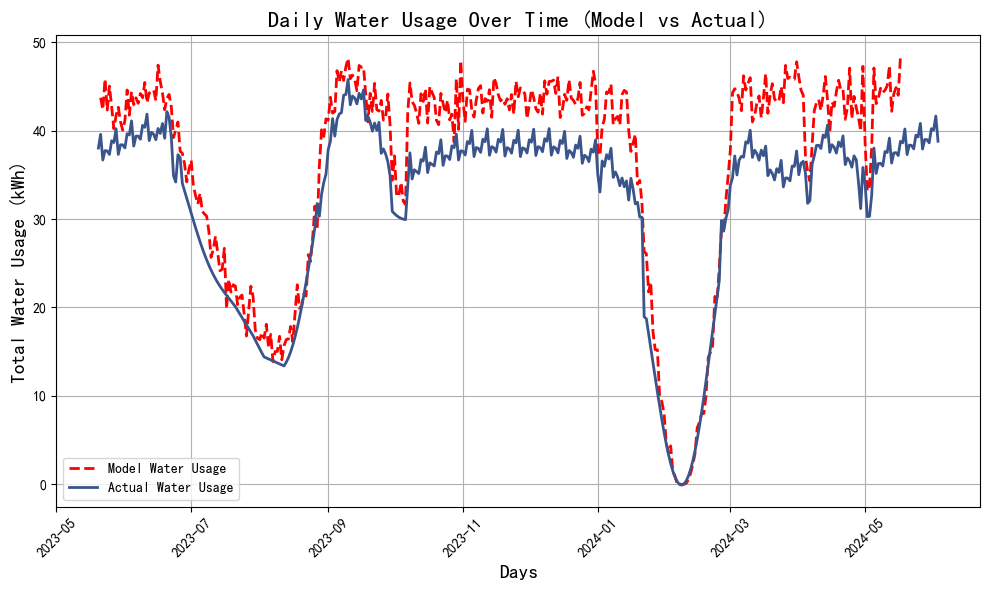

In [5]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 固定随机种子以保证结果可重复
random.seed(42)
np.random.seed(42)

# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 加载实景数据
actual_usage_file_path = 'filled_actual_usage.csv'  # 替换为你的实景数据文件路径
actual_usage_data = pd.read_csv(actual_usage_file_path, index_col=None)
actual_usage_data['ds'] = pd.to_datetime(actual_usage_data['ds'])
actual_usage_data = actual_usage_data.set_index('ds')

# 只取实景数据前365天
actual_usage_data = actual_usage_data.iloc[:363]

# 运行模型
model = StudentModel(num_agents=300, 
                     start_date="2023-05-20", 
                     holiday_effects=holiday_effects, 
                     beta=5, 
                     normal_env_ratio=(7, 3), 
                     num_neighbors=10, 
                     c_d_ratio=(0.3, 0.7),
                     interaction_interval=90)

# 运行363天的模拟
for _ in range(363):
    model.step()  # 调用模型的step方法，检查是否需要进行交互
    model.datacollector.collect(model)  # 收集数据

# 获取代理变量数据并进行汇总
water_data = model.datacollector.get_agent_vars_dataframe()

# 按照步骤 (Step) 汇总每个代理的 daily_usage
daily_usage = water_data.groupby("Step")["WaterUsage"].sum()/1000  # 获取该天的总用水量

# 将 step 转换为实际日期
daily_usage.index = [model.current_date - timedelta(days=(363 - step)) for step in daily_usage.index]  # 映射到实际日期
daily_usage.index.name = 'ds'  # 设置索引名称为 'ds'

model_data = daily_usage.to_frame()

# 可能需要调整日期范围，使两者对齐
model_data = model_data.join(actual_usage_data['actual_usage'], how='left')

# 可选：绘制每日用水量趋势图，包含模型数据和实景数据
plt.figure(figsize=(10, 6))

# 绘制模型数据
plt.plot(model_data.index, model_data['WaterUsage'], color='r', lw=2, linestyle='--', label='Model Water Usage')

# 绘制实景数据（如果有）
plt.plot(actual_usage_data.index, actual_usage_data['actual_usage'], color='#3A548C', lw=2, label='Actual Water Usage')

# 添加图例和标题
plt.title("Daily Water Usage Over Time (Model vs Actual)", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Total Water Usage (kWh)", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图表
plt.legend()
plt.show()


## 3.2 调整num_agents以最小化误差

In [ ]:
from sklearn.metrics import mean_squared_error

def calculate_mse(model_data, actual_data):
    return mean_squared_error(actual_data.dropna(), model_data.dropna())


In [9]:
# 固定随机种子以保证结果可重复
random.seed(42)
np.random.seed(42)

# 搜索范围
num_agents_range = range(360, 410, 10)  # 从100到2000，每次递增100

# 用于存储误差
errors = []

for num_agents in num_agents_range:
    # 运行模型
    model = StudentModel(num_agents=num_agents, 
                         start_date="2023-05-19", 
                         holiday_effects=holiday_effects, 
                         beta=0, 
                         normal_env_ratio=(5, 5), 
                         num_neighbors=10, 
                         c_d_ratio=(0.3, 0.7),
                         interaction_interval=360)

    # 模拟运行365天
    for _ in range(363):
        model.step()
        model.datacollector.collect(model)

    # 获取模型数据并对齐日期
    water_data = model.datacollector.get_agent_vars_dataframe()
    daily_usage = water_data.groupby("Step")["WaterUsage"].sum() / 1000
    daily_usage.index = [model.current_date - timedelta(days=(363 - step)) for step in daily_usage.index]
    daily_usage.index.name = 'ds'
    model_data = daily_usage.to_frame()
        
    # 计算误差（与实际数据对齐）
    model_data = model_data.join(actual_usage_data['actual_usage'], how='left')
    model_data['actual_usage']=model_data['actual_usage'].fillna(model_data['actual_usage'].rolling(10, min_periods=1).mean())

    mse = calculate_mse(model_data['WaterUsage'], model_data['actual_usage'])
    errors.append((num_agents, mse))

    print(f"num_agents={num_agents}, MSE={mse}")


NameError: name 'calculate_mse' is not defined

In [ ]:
# 找到最优 num_agents
optimal_num_agents, min_error = min(errors, key=lambda x: x[1])
print(f"最优 num_agents={optimal_num_agents}, 最小误差={min_error}")


In [75]:
# 计算R2分数
from sklearn.metrics import r2_score
model_data['actual_usage']=model_data['actual_usage'].fillna(model_data['actual_usage'].rolling(10, min_periods=1).mean())

# 计算R2分数
r2 = r2_score(model_data['actual_usage'], model_data['WaterUsage'])
print(f"R2 Score: {r2:.4f}")

R2 Score: 0.9481


In [ ]:
# 提取 num_agents 和误差
num_agents_list, mse_list = zip(*errors)

# 绘制曲线
plt.figure(figsize=(10, 6))
plt.plot(num_agents_list, mse_list, marker='o', linestyle='-', color='b')
plt.title("Error vs. Number of Agents", fontsize=16)
plt.xlabel("Number of Agents", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.grid(True)
plt.xticks(num_agents_list, rotation=45)
plt.tight_layout()

# 显示图表
plt.show()


## 3.3 保存最模型的最大最小范围

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 固定随机种子以保证结果可重复
random.seed(42)
np.random.seed(42)

# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 运行模型
model = StudentModel(num_agents=380, 
                     start_date="2023-05-19", 
                     holiday_effects=holiday_effects, 
                     beta=50.0, 
                     normal_env_ratio=(10, 0), 
                     num_neighbors=10, 
                     c_d_ratio=(0.5, 0.5),
                     interaction_interval=90)

# 运行365天的模拟
for _ in range(365):
    model.step()  # 调用模型的step方法，检查是否需要进行交互
    model.datacollector.collect(model)  # 收集数据

# 获取代理变量数据并进行汇总
water_data = model.datacollector.get_agent_vars_dataframe()

# 按照步骤 (Step) 汇总每个代理的 daily_usage
daily_usage = water_data.groupby("Step")["WaterUsage"].sum()/1000  # 获取该天的总用水量
# 将 step 转换为实际日期
daily_usage.index = [model.current_date - timedelta(days=(365 - step)) for step in daily_usage.index]  # 映射到实际日期
daily_usage.index.name = 'ds'  # 设置索引名称为 'ds'
# 将结果保存到 CSV 文件
daily_usage.to_csv("baseline_daily_usage_df_max.csv")

# 可选：绘制每日用水量趋势图
plt.figure(figsize=(10, 6))
daily_usage.plot(kind="line", color='b', lw=2)  # 蓝色线条，宽度为2
plt.title("Daily Water Usage Over Time", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Total Water Usage (kWh)", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图表
plt.show()


## 3.4 确定baseline

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 固定随机种子以保证结果可重复
random.seed(42)
np.random.seed(42)

# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 加载最大值和最小值文件
max_file_path = 'baseline_daily_usage_df_max.csv'  # 替换为你的最大值文件路径
min_file_path = 'baseline_daily_usage_df_min.csv'  # 替换为你的最小值文件路径

# 读取最大值和最小值数据
max_values = pd.read_csv(max_file_path, index_col=0)
min_values = pd.read_csv(min_file_path, index_col=0)

# 加载真实用水数据
actual_usage_file_path = 'filled_actual_usage.csv'  # 替换为你的真实数据文件路径
actual_usage_data = pd.read_csv(actual_usage_file_path, index_col=None)
actual_usage_data['ds'] = pd.to_datetime(actual_usage_data['ds'])
actual_usage_data = actual_usage_data.set_index('ds')
# 只取实景数据前365天
actual_usage_data = actual_usage_data.iloc[:365]


# 运行模型
model = StudentModel(num_agents=380, 
                     start_date="2023-05-19", 
                     holiday_effects=holiday_effects, 
                     beta=5.0, 
                     normal_env_ratio=(5, 5), 
                     num_neighbors=10, 
                     c_d_ratio=(0.3, 0.7),
                     interaction_interval=90)

# 运行365天的模拟
for _ in range(365):
    model.step()  # 调用模型的step方法，检查是否需要进行交互
    model.datacollector.collect(model)  # 收集数据

# 获取代理变量数据并进行汇总
water_data = model.datacollector.get_agent_vars_dataframe()

# 按照步骤 (Step) 汇总每个代理的 daily_usage
daily_usage = water_data.groupby("Step")["WaterUsage"].sum()/1000  # 获取该天的总用水量
# 将 step 转换为实际日期
daily_usage.index = [model.current_date - timedelta(days=(365 - step)) for step in daily_usage.index]  # 映射到实际日期
daily_usage.index.name = 'ds'  # 设置索引名称为 'ds'
# 获取最大值和最小值
max_daily_usage = max_values['WaterUsage']
min_daily_usage = min_values['WaterUsage']

# 可选：绘制每日用水量趋势图
plt.figure(figsize=(10, 6))

# 绘制阴影区域（最大值和最小值之间的区域）
plt.fill_between(daily_usage.index, min_daily_usage, max_daily_usage, color='gray', alpha=0.3, label='Min-Max Range')

# 绘制正常的每日用水量数据
plt.plot(daily_usage.index, daily_usage, color='b', lw=2, label='Daily Water Usage')
# 绘制真实用水量数据
plt.plot(actual_usage_data.index, actual_usage_data['actual_usage'], color='r', lw=2, linestyle='--', label='Actual Water Usage')

# 添加图例和标题
plt.title("Daily Water Usage Over Time (Model vs Actual with Min-Max Range)", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Total Water Usage (kWh)", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图表
plt.legend()
plt.show()

In [ ]:
daily_usage.index

## 3.5 baseline的基准线变化两图

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# 加载基准数据（baseline），确保日期列为 datetime 类型
baseline_daily_usage_df = pd.read_csv("baseline_daily_usage_df.csv")
baseline_daily_usage_df["date"] = pd.to_datetime(baseline_daily_usage_df["date"])  # 转换为 datetime 类型

# 使用直接的每日用水量数据创建 DataFrame
daily_usage_df = pd.DataFrame({
    "date": pd.date_range(start="2023-05-15", periods=365),  # 模拟日期
    "daily_usage": daily_usage.values  # 每日用水量数据
})

# 计算修改后的数据与基准数据的相对比例
baseline_daily_usage_df["daily_usage"] = baseline_daily_usage_df["daily_usage"] / 1000  # 转换为 m3
daily_usage_df["daily_usage"] = daily_usage_df["daily_usage"] / 1000  # 转换为 m3

# 合并数据以便计算比例
merged_df = pd.merge(baseline_daily_usage_df[['date', 'daily_usage']], 
                     daily_usage_df[['date', 'daily_usage']], 
                     on='date', 
                     suffixes=('_baseline', '_modified'))

# 计算每日用水量的比例
merged_df['usage_ratio'] = merged_df['daily_usage_modified'] / merged_df['daily_usage_baseline']

# 绘制每日用水量变化对比
plt.figure(figsize=(14, 8))

# 绘制基准数据（蓝色）
plt.subplot(2, 1, 1)  # 创建子图，第一张图
plt.plot(baseline_daily_usage_df["date"], baseline_daily_usage_df["daily_usage"], label="基准每日用水量 (m3)", color="blue")
plt.plot(daily_usage_df["date"], daily_usage_df["daily_usage"], label="修改后的每日用水量 (m3)", color="orange")
plt.title("每日用水量变化对比", fontsize=14)
plt.xlabel("日期", fontsize=12)
plt.ylabel("每日用水量 (m3)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# 绘制修改后的数据与基准数据的比例（第二张图）
plt.subplot(2, 1, 2)  # 创建子图，第二张图
plt.plot(merged_df["date"], merged_df['usage_ratio'], label="修改后的用水量与基准数据的比例", color="green")
plt.title("修改后的用水量与基准数据的相对比例", fontsize=14)
plt.xlabel("日期", fontsize=12)
plt.ylabel("比例", fontsize=12)
plt.grid(True)
plt.tight_layout()  # 自动调整布局
plt.show()

In [ ]:
# model = StudentModel(num_agents=1000, start_date="2023-05-15", holiday_effects=holiday_effects)
for agent in model.schedule.agents:
    print(f"Agent {agent.unique_id}: Profile = {agent.profile}")


# 4. Discussion

## 4.1 c_d, normal, betas遍历 

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from multiprocessing import Pool

# 固定随机种子以保证结果可重复
random.seed(42)
np.random.seed(42)

# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 加载最大值和最小值文件（如果仅保存Excel，可不做绘图相关预处理）
max_file_path = 'baseline_daily_usage_df_max.csv'
min_file_path = 'baseline_daily_usage_df_min.csv'
max_values = pd.read_csv(max_file_path, index_col=0)
min_values = pd.read_csv(min_file_path, index_col=0)

# 参数遍历设置
c_d_ratios = [(0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3)]
normal_env_ratios = [(9, 1), (8, 2)]
betas = [5, 10, 25]

def simulate_task(params):
    """
    针对单个 (normal_env_ratio, beta) 参数组合，遍历所有 c_d_ratio 并运行 365 天模拟，
    返回该参数组合下所有的模拟结果。
    """
    normal_env_ratio, beta = params
    current_results = []
    # 为避免多进程中随机种子一致，可以基于参数设置不同的种子
    seed = hash((normal_env_ratio, beta)) % 2**32
    random.seed(seed)
    np.random.seed(seed)
    start_time = datetime.now()
    
    # 对于每个 c_d_ratio 进行模拟
    for c_d_ratio in c_d_ratios:
        # 初始化模型（假设 StudentModel 已定义并已导入）
        model = StudentModel(
            num_agents=380,
            start_date="2023-05-19",
            holiday_effects=holiday_effects,
            beta=beta,
            normal_env_ratio=normal_env_ratio,
            num_neighbors=10,
            c_d_ratio=c_d_ratio,
            interaction_interval=30  # 固定为 30
        )
    
        # 运行365天的模拟（注意：model.step() 内部已收集数据，不需重复调用收集函数）
        for _ in range(365):
            model.step()
    
        # 获取代理变量数据并汇总每日用水量
        water_data = model.datacollector.get_agent_vars_dataframe()
        daily_usage = water_data.groupby("Step")["WaterUsage"].sum() / 1000  # 单位转换
        # 将 step 转换为实际日期
        daily_usage.index = [model.current_date - timedelta(days=(365 - step)) for step in daily_usage.index]
        daily_usage.index = pd.to_datetime(daily_usage.index).tz_localize(None)
        daily_usage.index.name = 'ds'
    
        # 计算 'environmentalist' 和 'normal' 代理人的数量
        total_agents = len(model.schedule.agents)
        env_total = sum(1 for agent in model.schedule.agents if agent.profile == 'environmentalist')
        normal_total = total_agents - env_total
        env_normal_ratio = (env_total / total_agents, normal_total / total_agents)
    
        # 保存每日数据到 current_results
        for date, usage in daily_usage.items():
            current_results.append({
                "c_d_ratio": c_d_ratio,
                "beta": beta,
                "normal_env_ratio": normal_env_ratio,
                "date": date,
                "water_usage": usage,
                "env_ratio": env_normal_ratio[0],
                "normal_ratio": env_normal_ratio[1]
            })
    
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print(f"Simulation for normal_env_ratio={normal_env_ratio}, beta={beta} completed in {elapsed_time}")
    
    # 返回该 (normal_env_ratio, beta) 组合的结果
    return (normal_env_ratio, beta, current_results)

import cProfile

if __name__ == '__main__':
    # 先对单个任务进行性能分析，避免多进程干扰
    test_params = (normal_env_ratios[0], betas[0])
    cProfile.run('simulate_task(test_params)')
    
    # 如果分析完毕后，再运行所有任务
    tasks = [(normal_env_ratio, beta) for normal_env_ratio in normal_env_ratios for beta in betas]
    from multiprocessing import Pool, cpu_count
    with Pool(processes=8) as pool:
        results = pool.map(simulate_task, tasks)
    
    # 每个参数组合保存为单独的文件（或合并写入一个文件）
    for (normal_env_ratio, beta, current_results) in results:
        result_df = pd.DataFrame(current_results)
        output_file = f"30%_education_simulation_results_r_{normal_env_ratio}_beta_{beta}.xlsx"
        result_df.to_excel(output_file, index=False)
        print(f"Simulation results saved to {output_file}")
    
    print("All simulations complete.")


In [ ]:
import multiprocessing 

multiprocessing.cpu_count()

结论：
（1）β=5 是一个比较温和的策略；

（2）Normal：Environmentalist = 6:4 是一个比较平衡的策略；

（3）c_d_ratio=0.5 和 参加清洁生产导论的学生=[]比例关系，需要讨论



In [ ]:
model = StudentModel(
    num_agents=380,
    start_date="2023-05-19",
    holiday_effects=holiday_effects,
    beta=beta,
    normal_env_ratio=normal_env_ratio,
    num_neighbors=10,
    c_d_ratio=c_d_ratio,
    interaction_interval=30  # 固定为 30
)

# 运行365天的模拟
for _ in range(365):
    model.step()  # 调用模型的step方法，检查是否需要进行交互
    model.datacollector.collect(model)  # 收集数据

# 获取代理变量数据并进行汇总
water_data = model.datacollector.get_agent_vars_dataframe()

# 按照步骤 (Step) 汇总每个代理的 daily_usage
daily_usage = water_data.groupby("Step")["WaterUsage"].sum()/1000  # 获取该天的总用水量


In [ ]:

# 运行模型
# model = StudentModel(num_agents=1000, start_date="2023-05-15", holiday_effects=holiday_effects, beta=1.0)
agents_data = pd.DataFrame([
    {
        "faculty": agent.faculty,
        "grade": agent.grade,
        "green_education": agent.green_education,
        "profile": agent.profile
    }
    for agent in model.schedule.agents
])

## 4.2 对于教育接受教育的讨论【StudentModel-AgentModel的更广参数比例】

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates  # 用于处理日期刻度

# 固定随机种子以保证结果可重复
random.seed(42)
np.random.seed(42)

# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 加载最大值和最小值文件
max_file_path = 'baseline_daily_usage_df_max.csv'  # 替换为你的最大值文件路径
min_file_path = 'baseline_daily_usage_df_min.csv'  # 替换为你的最小值文件路径

# 读取最大值和最小值数据
max_values = pd.read_csv(max_file_path, index_col=0)
min_values = pd.read_csv(min_file_path, index_col=0)

# 参数遍历设置
c_d_ratios = [(0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3)]
course_attendance_ratios = [
    {"A": [13, 30, 24, 13], "B": [4, 7, 6, 3], "C": [4, 7, 6, 3], "D": [1, 2, 1, 1]},  # 原始比例
    {"A": [26, 60, 48, 26], "B": [8, 14, 12, 6], "C": [8, 14, 12, 6], "D": [2, 4, 2, 2]},  # 加倍比例
    {"A": [39, 90, 72, 39], "B": [12, 21, 18, 9], "C": [12, 21, 18, 9], "D": [3, 6, 3, 3]},  # 三倍比例
    {"A": [52, 120, 96, 52], "B": [16, 28, 24, 12], "C": [12, 21, 18, 9], "D": [3, 6, 3, 3]},  # 四倍比例
    {"A": [65, 150, 120, 65], "B": [20, 35, 30, 15], "C": [12, 21, 18, 9], "D": [3, 6, 3, 3]}  # 五倍比例
]

# 遍历所有组合
for cour in course_attendance_ratios:
    plt.figure(figsize=(12, 8))  
    max_values.index = pd.to_datetime(max_values.index)  # 将索引转换为日期时间格式 
    # 绘制阴影区域（最大值和最小值之间的区域）
    plt.fill_between(
        max_values.index, min_values['WaterUsage'], max_values['WaterUsage'], 
        color='gray', alpha=0.3, label='Min-Max Range'
    )

    # 用于存储当前模拟的结果
    current_results = []
    for c_d_ratio in c_d_ratios:
        # 运行模型
        model = StudentModel(
            num_agents=380,
            start_date="2023-05-19",
            holiday_effects=holiday_effects,
            beta=5,
            normal_env_ratio=(6,4),
            num_neighbors=10,
            c_d_ratio=c_d_ratio,
            interaction_interval=30,  # 固定为 30
            course_attendance_ratio=cour
        )

        # 运行365天的模拟
        for _ in range(365):
            model.step()  # 调用模型的step方法，检查是否需要进行交互
            model.datacollector.collect(model)  # 收集数据

        # 获取代理变量数据并进行汇总
        water_data = model.datacollector.get_agent_vars_dataframe()

        # 按照步骤 (Step) 汇总每个代理的 daily_usage
        daily_usage = water_data.groupby("Step")["WaterUsage"].sum()/1000  # 获取该天的总用水量
        # 将 step 转换为实际日期
        daily_usage.index = [model.current_date - timedelta(days=(365 - step)) for step in daily_usage.index]
        daily_usage.index = pd.to_datetime(daily_usage.index).tz_localize(None)

        # 设置索引名称为 'ds'
        daily_usage.index.name = 'ds'  # 设置索引名称为 'ds'

        # 绘制当前组合的模拟结果
        plt.plot(
            daily_usage.index,
            daily_usage,
            lw=2,
            label=f"c_d_ratio={c_d_ratio}",
        )

        # 计算 'environmentalist' 和 'normal' 代理人的数量
        env_total = sum(1 for agent in model.schedule.agents if agent.profile == 'environmentalist')
        normal_total = sum(1 for agent in model.schedule.agents if agent.profile == 'normal')

        # 计算总代理人数量
        total_agents = len(model.schedule.agents)

        # 计算每类代理人的比例
        env_normal_ratio = env_total / total_agents, normal_total / total_agents

        # 保存每一天的用水量数据到 current_results
        for date, usage in daily_usage.items():
            current_results.append({
                "c_d_ratio": c_d_ratio,  # 循环参数之一
                "course_attendance_ratio": cour,  # 循环参数之二
                "date": date,  # 日期
                "water_usage": usage,  # 用水量
                "env_ratio": env_normal_ratio[0],  # 环保型代理人的比例
                "normal_ratio": env_normal_ratio[1]  # 普通代理人的比例
            })

    # 修改标题，使用 c_d_ratio 和 course_attendance_ratio 的信息
    attendance_ratio_sum = sum(cour["A"])  # 获取当前 course_attendance_ratio 的总和
    plt.title(
        f"Daily Water Usage (c_d_ratio={c_d_ratio}, course_sum={attendance_ratio_sum})",
        fontsize=16
    )
    plt.xlabel("Days", fontsize=14)
    plt.ylabel("Total Water Usage (kWh)", fontsize=14)
    plt.grid(True)

    # 优化横坐标日期显示
    ax = plt.gca()  # 获取当前轴
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # 每月显示一个标签
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 设置日期格式
    plt.xticks(rotation=45)  # 旋转标签避免重叠

    plt.tight_layout()  # 自动调整布局
    plt.legend()
    output_image = f"simulation_cdr_{c_d_ratio}_cour_{attendance_ratio_sum}.png"
    plt.savefig(output_image)
    plt.close()

    # 将当前结果保存为 Excel 文件
    result_df = pd.DataFrame(current_results)
    output_file = f"simulation_results_cdr_{c_d_ratio}_cour_{attendance_ratio_sum}.xlsx"
    result_df.to_excel(output_file, index=False)

    print(f"Simulation results saved to {output_file}")

print("All simulations complete.")


## 4.3 对于所有参数的初步讨论

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates  # 用于处理日期刻度

# 固定随机种子以保证结果可重复
random.seed(42)
np.random.seed(42)

# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 加载最大值和最小值文件
max_file_path = 'baseline_daily_usage_df_max.csv'  # 替换为你的最大值文件路径
min_file_path = 'baseline_daily_usage_df_min.csv'  # 替换为你的最小值文件路径

# 读取最大值和最小值数据
max_values = pd.read_csv(max_file_path, index_col=0)
min_values = pd.read_csv(min_file_path, index_col=0)

# 参数遍历设置
c_d_ratios = [(0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3)]
course_attendance_ratios = [
    {"A": [13, 30, 24, 13], "B": [4, 7, 6, 3], "C": [4, 7, 6, 3], "D": [1, 2, 1, 1]},  # 原始比例
    {"A": [26, 60, 48, 26], "B": [8, 14, 12, 6], "C": [8, 14, 12, 6], "D": [2, 4, 2, 2]},  # 加倍比例
    {"A": [39, 90, 72, 39], "B": [12, 21, 18, 9], "C": [12, 21, 18, 9], "D": [3, 6, 3, 3]},  # 三倍比例
    {"A": [52, 120, 96, 52], "B": [16, 28, 24, 12], "C": [12, 21, 18, 9], "D": [3, 6, 3, 3]},  # 四倍比例
    {"A": [65, 150, 120, 65], "B": [20, 35, 30, 15], "C": [12, 21, 18, 9], "D": [3, 6, 3, 3]}  # 五倍比例
]
num_neighbors_list = [6, 10, 20, 35, 50]  # 新增的 num_neighbors 参数
normal_env_ratios = [ (5, 5),(6, 4),(7, 3),(8, 2),(9, 1)]  # 新增的 normal_env_ratio 参数

# 遍历所有组合
for normal_env_ratio in normal_env_ratios:
    for num_neighbors in num_neighbors_list:
        for cour in course_attendance_ratios:
            plt.figure(figsize=(12, 8))  
            max_values.index = pd.to_datetime(max_values.index)  # 将索引转换为日期时间格式 
            # 绘制阴影区域（最大值和最小值之间的区域）
            plt.fill_between(
                max_values.index, min_values['WaterUsage'], max_values['WaterUsage'], 
                color='gray', alpha=0.3, label='Min-Max Range'
            )

            # 用于存储当前模拟的结果
            current_results = []
            for c_d_ratio in c_d_ratios:
                # 运行模型
                model = StudentModel(
                    num_agents=380,
                    start_date="2023-05-19",
                    holiday_effects=holiday_effects,
                    beta=5,
                    normal_env_ratio=normal_env_ratio,  # 动态传入 normal_env_ratio
                    num_neighbors=num_neighbors,  # 动态传入 num_neighbors
                    c_d_ratio=c_d_ratio,
                    interaction_interval=30,  # 固定为 30
                    course_attendance_ratio=cour
                )

                # 运行365天的模拟
                for _ in range(365):
                    model.step()  # 调用模型的step方法，检查是否需要进行交互
                    model.datacollector.collect(model)  # 收集数据

                # 获取代理变量数据并进行汇总
                water_data = model.datacollector.get_agent_vars_dataframe()

                # 按照步骤 (Step) 汇总每个代理的 daily_usage
                daily_usage = water_data.groupby("Step")["WaterUsage"].sum()/1000  # 获取该天的总用水量
                # 将 step 转换为实际日期
                daily_usage.index = [model.current_date - timedelta(days=(365 - step)) for step in daily_usage.index]
                daily_usage.index = pd.to_datetime(daily_usage.index).tz_localize(None)

                # 设置索引名称为 'ds'
                daily_usage.index.name = 'ds'  # 设置索引名称为 'ds'

                # 绘制当前组合的模拟结果
                plt.plot(
                    daily_usage.index,
                    daily_usage,
                    lw=2,
                    label=f"c_d_ratio={c_d_ratio}",
                )

                # 计算 'environmentalist' 和 'normal' 代理人的数量
                env_total = sum(1 for agent in model.schedule.agents if agent.profile == 'environmentalist')
                normal_total = sum(1 for agent in model.schedule.agents if agent.profile == 'normal')

                # 计算总代理人数量
                total_agents = len(model.schedule.agents)

                # 计算每类代理人的比例
                env_normal_ratio = env_total / total_agents, normal_total / total_agents

                # 保存每一天的用水量数据到 current_results
                for date, usage in daily_usage.items():
                    current_results.append({
                        "c_d_ratio": c_d_ratio,  # 循环参数之一
                        "course_attendance_ratio": cour,  # 循环参数之二
                        "num_neighbors": num_neighbors,  # 新增参数
                        "normal_env_ratio": normal_env_ratio,  # 新增参数
                        "date": date,  # 日期
                        "water_usage": usage,  # 用水量
                        "env_ratio": env_normal_ratio[0],  # 环保型代理人的比例
                        "normal_ratio": env_normal_ratio[1]  # 普通代理人的比例
                    })

            # 修改标题，使用动态参数信息
            attendance_ratio_sum = sum(cour["A"])  # 获取当前 course_attendance_ratio 的总和
            plt.title(
                f"Daily Water Usage (num_neighbors={num_neighbors}, normal_env_ratio={normal_env_ratio}, course_sum={attendance_ratio_sum})",
                fontsize=16
            )
            plt.xlabel("Days", fontsize=14)
            plt.ylabel("Total Water Usage (kWh)", fontsize=14)
            plt.grid(True)

            # 优化横坐标日期显示
            ax = plt.gca()  # 获取当前轴
            ax.xaxis.set_major_locator(mdates.MonthLocator())  # 每月显示一个标签
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 设置日期格式
            plt.xticks(rotation=45)  # 旋转标签避免重叠

            plt.tight_layout()  # 自动调整布局
            plt.legend()
            output_image = f"simulation_neighbors_{num_neighbors}_normal_{normal_env_ratio[0]}_{normal_env_ratio[1]}_cdr_{c_d_ratio}_cour_{attendance_ratio_sum}.png"
            plt.savefig(output_image)
            plt.close()

            # 将当前结果保存为 Excel 文件
            result_df = pd.DataFrame(current_results)
            output_file = f"simulation_neighbors_{num_neighbors}_normal_{normal_env_ratio[0]}_{normal_env_ratio[1]}_cdr_{c_d_ratio}_cour_{attendance_ratio_sum}.xlsx"
            result_df.to_excel(output_file, index=False)

            print(f"Simulation results saved to {output_file}")

print("All simulations complete.")


In [ ]:

# 运行模型
# model = StudentModel(num_agents=1000, start_date="2023-05-15", holiday_effects=holiday_effects, beta=1.0)
agents_data = pd.DataFrame([
    {
        "faculty": agent.faculty,
        "grade": agent.grade,
        "green_education": agent.green_education,
        "profile": agent.profile
    }
    for agent in model.schedule.agents
])

## 4.4 对于每组交互个数&交互次数的讨论

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates  # 用于处理日期刻度

# 固定随机种子以保证结果可重复
random.seed(42)
np.random.seed(42)

# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 加载最大值和最小值文件
max_file_path = 'baseline_daily_usage_df_max.csv'  # 替换为你的最大值文件路径
min_file_path = 'baseline_daily_usage_df_min.csv'  # 替换为你的最小值文件路径

# 读取最大值和最小值数据
max_values = pd.read_csv(max_file_path, index_col=0)
min_values = pd.read_csv(min_file_path, index_col=0)

# 参数遍历设置
interaction_intervals = [30, 60, 90, 120, 180]  # 新增的 interaction_interval 参数
num_neighbors_list = [6, 10, 20, 35, 50]  # 新增的 num_neighbors 参数

# 遍历所有组合
for neighbor in num_neighbors_list:
    plt.figure(figsize=(12, 8))  
    max_values.index = pd.to_datetime(max_values.index)  # 将索引转换为日期时间格式 
    # 绘制阴影区域（最大值和最小值之间的区域）
    plt.fill_between(
        max_values.index, min_values['WaterUsage'], max_values['WaterUsage'], 
        color='gray', alpha=0.3, label='Min-Max Range'
    )

    # 用于存储当前模拟的结果
    current_results = []
    for Interval in interaction_intervals:
        # 运行模型
        model = StudentModel(
            num_agents=380,
            start_date="2023-05-19",
            holiday_effects=holiday_effects,
            beta=5,
            normal_env_ratio=(7,3),
            num_neighbors= neighbor,  # 动态传入 num_neighbors
            c_d_ratio=(0.6, 0.4),
            interaction_interval=Interval,  # 固定为 30
            course_attendance_ratio= {"A": [39, 90, 72, 39], "B": [12, 21, 18, 9], "C": [12, 21, 18, 9], "D": [3, 6, 3, 3]}
        )

        # 运行365天的模拟
        for _ in range(365):
            model.step()  # 调用模型的step方法，检查是否需要进行交互
            model.datacollector.collect(model)  # 收集数据

        # 获取代理变量数据并进行汇总
        water_data = model.datacollector.get_agent_vars_dataframe()

        # 按照步骤 (Step) 汇总每个代理的 daily_usage
        daily_usage = water_data.groupby("Step")["WaterUsage"].sum()/1000  # 获取该天的总用水量
        # 将 step 转换为实际日期
        daily_usage.index = [model.current_date - timedelta(days=(365 - step)) for step in daily_usage.index]
        daily_usage.index = pd.to_datetime(daily_usage.index).tz_localize(None)

        # 设置索引名称为 'ds'
        daily_usage.index.name = 'ds'  # 设置索引名称为 'ds'

        # 绘制当前组合的模拟结果
        plt.plot(
            daily_usage.index,
            daily_usage,
            lw=2,
            label=f"interaction_interval={Interval}",
        )

        # 计算 'environmentalist' 和 'normal' 代理人的数量
        env_total = sum(1 for agent in model.schedule.agents if agent.profile == 'environmentalist')
        normal_total = sum(1 for agent in model.schedule.agents if agent.profile == 'normal')

        # 计算总代理人数量
        total_agents = len(model.schedule.agents)

        # 计算每类代理人的比例
        env_normal_ratio = env_total / total_agents, normal_total / total_agents

        # 保存每一天的用水量数据到 current_results
        for date, usage in daily_usage.items():
            current_results.append({
                "interaction_interval": Interval,  # 新增参数
                "num_neighbors": neighbor,  # 新增参数
                "date": date,  # 日期
                "water_usage": usage,  # 用水量
                "env_ratio": env_normal_ratio[0],  # 环保型代理人的比例
                "normal_ratio": env_normal_ratio[1]  # 普通代理人的比例
            })

    # 修改标题，使用 num_neighbors 和 interaction_interval 的信息
    plt.title(
        f"Daily Water Usage (num_neighbors={neighbor})",
        fontsize=16
    )
    plt.xlabel("Days", fontsize=14)
    plt.ylabel("Total Water Usage (kWh)", fontsize=14)
    plt.grid(True)


    # 优化横坐标日期显示
    ax = plt.gca()  # 获取当前轴
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # 每月显示一个标签
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 设置日期格式
    plt.xticks(rotation=45)  # 旋转标签避免重叠

    plt.tight_layout()  # 自动调整布局
    plt.legend()
    output_image = f"simulation_neighbors_{neighbor}.png"
    plt.savefig(output_image)
    plt.close()


    # 将当前结果保存为 Excel 文件
    result_df = pd.DataFrame(current_results)
    output_file = f"simulation_results_neighbors_{neighbor}.xlsx"
    result_df.to_excel(output_file, index=False)

    print(f"Simulation results saved to {output_file}")

print("All simulations complete.")


## 4.5 对于在扩散中引入时间变量的讨论（季节变化的熵分析加入扩散模型）

# 5.结果

## 5.1 不同分年级分专业的人效果

In [6]:
# 打印模型中Normal学生平均用水量
normal_students = [agent for agent in model.schedule.agents if agent.profile == "normal"]
normal_daily_usage = [agent.calculate_daily_water_usage() for agent in normal_students]
print("Normal学生平均用水量：", np.mean(normal_daily_usage))

# 打印模型中Environmentalist学生平均用水量
environmentalist_students = [agent for agent in model.schedule.agents if agent.profile == "environmentalist"]
environmentalist_daily_usage = [agent.calculate_daily_water_usage() for agent in environmentalist_students]
print("Environmentalist学生平均用水量：", np.mean(environmentalist_daily_usage))




Normal学生平均用水量： 153.0632299287753
Environmentalist学生平均用水量： 131.28760009196677


In [60]:
water_data = model.datacollector.get_agent_vars_dataframe()


In [110]:
# 获取数据收集器记录的数据
df = model.datacollector.get_agent_vars_dataframe()

# df 是一个 MultiIndex DataFrame，其索引为 (Step, AgentID)
# 筛选出每个时间步中当时 Profile 为 "environmentalist" 的记录
env_data = df[df["Profile"] == "environmentalist"]

# 按照 Step 分组，计算每天环境型代理的平均用水量
env_daily_mean = env_data.groupby("Step")["WaterUsage"].mean()

# 计算363天内环境型学生的总体平均用水量
overall_env_mean = env_daily_mean.mean()

print("363天内环境型学生的总体平均用水量：", overall_env_mean)

# 对normal学生进行同样的计算
normal_data = df[df["Profile"] == "normal"]
normal_daily_mean = normal_data.groupby("Step")["WaterUsage"].mean()
overall_normal_mean = normal_daily_mean.mean()
print("363天内普通学生的总体平均用水量：", overall_normal_mean)



363天内环境型学生的总体平均用水量： 96.33908616768996
363天内普通学生的总体平均用水量： 128.2810602236117


In [ ]:
# 统计学生社会学信息并绘图
def plot_student_statistics(model):
    """
    根据生成的 agents 统计学生的社会学信息（专业、绿色教育、行为类型）并绘制图表。
    Args:
        model: StudentModel 对象
    """

    # 获取所有学生主体的属性
    agents_data = pd.DataFrame([
        {
            "faculty": agent.faculty,
            "grade": agent.grade,
            "green_education": agent.green_education,
            "profile": agent.profile
        }
        for agent in model.schedule.agents
    ])

    # 设置年级的排序顺序
    agents_data["grade"] = pd.Categorical(
    agents_data["grade"],
    categories=["大一", "大二", "大三", "大四"],
    ordered=True
)

    # 绘制学生专业和年级分布
    faculty_grade_distribution = agents_data.groupby(["grade", "faculty"]).size().unstack(fill_value=0)
    faculty_grade_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title("学生专业分布", fontsize=14)
    plt.xlabel("年级", fontsize=12)
    plt.ylabel("学生人数", fontsize=12)
    plt.legend(title="专业", fontsize=12)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


    # 提取已参与绿色教育的学生并按专业划分
    green_education_faculty_distribution = agents_data[agents_data["green_education"] == True] \
        .groupby(["grade", "faculty"]).size().unstack(fill_value=0)
    # 创建绘图
    fig, ax = plt.subplots(figsize=(12, 8))
    # 绘制已参与部分，按专业分堆叠
    green_education_faculty_distribution.plot(kind="bar", stacked=True, ax=ax, colormap="tab10", alpha=0.8 )
    # 设置图表标题和标签
    plt.title("学生绿色教育参与情况（已参与按专业划分）", fontsize=14)
    plt.xlabel("年级", fontsize=12)
    plt.ylabel("学生人数", fontsize=12)
    plt.legend(title="绿色教育与专业", fontsize=12)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

    # 绘制学生行为类型分布
    profile_distribution = agents_data["profile"].value_counts()
    profile_distribution.plot(kind='bar', figsize=(8, 6), color='skyblue')
    plt.title("学生行为类型分布", fontsize=14)
    plt.xlabel("行为类型", fontsize=12)
    plt.ylabel("学生人数", fontsize=12)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
plot_student_statistics(model)

# 6.废弃的代码

In [51]:

class StudentModel(Model):
    def __init__(self, num_agents, start_date, holiday_effects, beta=1.0, normal_env_ratio=(7, 3), num_neighbors=4, c_d_ratio=(0.5, 0.5), interaction_interval=30):
        # 显式调用父类的初始化方法
        super().__init__()
        self.num_agents = num_agents
        self.holiday_effects = holiday_effects
        self.schedule = RandomActivation(self)
        
        # 初始化模拟开始日期
        self.current_date = datetime.strptime(start_date, "%Y-%m-%d")

        # 社会学比例
        self.faculty_total_ratio = {"A": [100, 100, 100, 100], "B": [100, 100, 100, 100], "C": [25, 25, 25, 25], "D": [25, 25, 25, 25]}
        self.course_attendance_ratio = {"A": [13, 30, 24, 13], "B": [4, 7, 6, 3], "C": [4, 7, 6, 3], "D": [1, 2, 1, 1]}  # 1倍比例
        
        # 创建数据收集器
        self.datacollector = DataCollector(
            agent_reporters={
                "WaterUsage": lambda a: a.get_water(),  # 调用 get_water 方法并记录其返回值
                "Profile": lambda a: a.profile
            }
        )
        self.interaction_groups = []  # 存储分组信息
        # 设置 beta 参数，默认为 1.0
        self.beta = beta
        self.num_neighbors = num_neighbors  # Number of neighbors for each agent
        self.c_d_ratio = c_d_ratio  # Store the c_d_ratio
        self.interaction_interval = interaction_interval
        self.normal_env_ratio = normal_env_ratio  # Store the ratio
        self.create_agents()

                
    def create_agents(self):
        """创建学生主体并加入调度器。"""
        # 打印调试信息，确保 c_d_ratio 被正确传递
        
        for i in range(self.num_agents):
            faculty, grade = self.assign_faculty_and_grade()
            green_education = self.assign_green_education(faculty, grade)
            profile = self.assign_profile()
            summer_start, summer_end = "2023-06-11", "2023-08-29"
            winter_start, winter_end = "2024-01-15", "2024-03-01"
            agent = StudentAgent(
                unique_id=i,
                model=self,
                summer_start=summer_start,
                summer_end=summer_end,
                winter_start=winter_start,
                winter_end=winter_end,
                holiday_effects=self.holiday_effects,
                profile=profile,
                grade=grade,
                faculty=faculty,
                green_education=green_education,
                c_d_ratio=self.c_d_ratio
            )
            self.schedule.add(agent)

    def assign_faculty_and_grade(self):
        """根据比例随机分配专业和年级。"""
        faculty = random.choices(population=list(self.faculty_total_ratio.keys()), weights=[sum(self.faculty_total_ratio[f]) for f in self.faculty_total_ratio])[0]
        grade = random.choices(population=["大一", "大二", "大三", "大四"], weights=self.faculty_total_ratio[faculty])[0]
        return faculty, grade

    def assign_green_education(self, faculty, grade):
        """根据课程比例决定是否参加绿色教育。"""
        grades = ["大一", "大二", "大三", "大四"]
        grade_index = grades.index(grade)
        course_ratio = self.course_attendance_ratio[faculty][grade_index]
        total_students_in_grade = self.faculty_total_ratio[faculty][grade_index]
        return random.random() < (course_ratio / total_students_in_grade)

    def assign_profile(self):
        """根据外部输入的比例分配 Normal 和 Environmentalist。"""
        normal_weight, env_weight = self.normal_env_ratio  # Use the external ratio
        return random.choices(population=["normal", "environmentalist"], weights=[normal_weight, env_weight])[0]
        
    def create_interaction_groups(self):
        """根据小世界网络生成代理的交互组"""
        # 创建小世界网络
        G = nx.watts_strogatz_graph(self.num_agents, self.num_neighbors, 0.2)  # 4个邻居，重连概率为0.2

        # 基于年级、学科、是否参加清洁生产导论课程建立连接
        for node in G.nodes():
            agent = self.agents[node]
            neighbors = list(G.neighbors(node))
            
            # 确保每个邻居的连接是双向的
            for neighbor in neighbors:
                # 确保在邻居的列表中也有反向链接
                if agent.grade == self.agents[neighbor].grade:
                    G[node][neighbor]['weight'] = 2
                elif agent.faculty == self.agents[neighbor].faculty:
                    G[node][neighbor]['weight'] = 1.5
                elif agent.green_education == self.agents[neighbor].green_education:
                    G[node][neighbor]['weight'] = 1.2
                else:
                    G[node][neighbor]['weight'] = 1

        # 确保每个代理的邻居是双向的
        self.interaction_groups = []
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            group = [(self.agents[node], [self.agents[neighbor] for neighbor in neighbors])]
            self.interaction_groups.append(group)
        
        # 输出调试信息，查看是否是双向连接
        # print(f"Created {len(self.interaction_groups)} interaction groups.")

        # 检查每个代理的邻居是否双向连接
        for node in G.nodes():
            # print(f"Checking neighbors for Node {node}")
            # print(list(G.neighbors(node)))
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                if node not in list(G.neighbors(neighbor)):
                    print(f"Warning: Node {node} and Node {neighbor} are not bidirectional.")
        
    def interact_agents(self):
        """
        处理每组内的交互逻辑。
        """
        # 用来保存所有代理的行为更新决策
        updates = []

        # 对每个组进行交互
        for group in self.interaction_groups:
            for agent, neighbors in group:
                # 统计邻居行为
                neighbors_behavior = {
                    "environmentalist": sum(1 for a in neighbors if a.profile == "environmentalist") / len(neighbors),
                    "normal": sum(1 for a in neighbors if a.profile == "normal") / len(neighbors),
                }

                # 计算行为效用并决定是否更新行为
                if agent.profile == "environmentalist":
                    U_env_to_env, U_env_to_normal = agent.calculate_behavior_utilities(neighbors_behavior)
                    # 在计算效用时乘以 beta
                    U_env_to_env *= self.beta
                    U_env_to_normal *= self.beta
                    P_env_to_env = np.exp(U_env_to_env) / (np.exp(U_env_to_env) + np.exp(U_env_to_normal))
                    updates.append((agent, "environmentalist" if random.random() < P_env_to_env else "normal"))
                else:  # agent.profile == "normal"
                    U_normal_to_env, U_normal_to_normal = agent.calculate_behavior_utilities(neighbors_behavior)
                    # 在计算效用时乘以 beta
                    U_normal_to_env *= self.beta
                    U_normal_to_normal *= self.beta
                    P_normal_to_env = np.exp(U_normal_to_env) / (np.exp(U_normal_to_env) + np.exp(U_normal_to_normal))
                    updates.append((agent, "environmentalist" if random.random() < P_normal_to_env else "normal"))

        # 一轮交互结束后，再统一更新所有代理的状态
        for agent, new_profile in updates:
            agent.profile = new_profile
            # print(f"Agent {agent.unique_id} updated to: {agent.profile}")


    def step(self):
        """运行模型单步。"""
        # 1. 更新日期
        # print(f"Running step for {self.current_date}")
        self.current_date += timedelta(days=1)
        # 2. 每30天进行一次学生交互
        if (self.current_date - datetime.strptime("2023-05-20", "%Y-%m-%d")).days % self.interaction_interval == 0:
            self.create_interaction_groups()  # 创建新的交互组
            # print(f"Running interaction for {self.current_date}")
            self.interact_agents()

        # 2. 更新每个代理的状态
        self.schedule.step()
        

        # 3. 收集每日数据（如每个学生的用水量）
        self.datacollector.collect(self)

    def get_collected_data(self):
        """获取已收集的数据，返回DataFrame格式以便后续分析或绘图。"""
        return self.datacollector.get_agent_vars_dataframe()    


